# Problem Statement

Build an optimal model that can help us identify bot traffic coming  from search engines i.e non-human traffic(NHT) and human traffic (HT).

# 1)-Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [3]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# For modeling building and tunning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
# For neural net

from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [0]:
# for evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 2)-Loading data

In [7]:
df = pd.read_pickle('clickdata.pkl')
df.head()

,labels,visitor_recognition_type,country_by_ip_address,region_by_ip_address
0,NHT,ANONYMOUS,US,CA
1,NHT,ANONYMOUS,US,CA
2,HT,ANONYMOUS,IT,LI
3,NHT,ANONYMOUS,US,CA
4,NHT,ANONYMOUS,US,CA


In [8]:
df.shape

(59638, 4)

In [9]:
df.labels.value_counts()

HT     38497
NHT    21141
Name: labels, dtype: int64

In [10]:
n_group = df['labels'].value_counts()
n_group_sum = n_group.sum()

print('Human Traffic: {}'.format(n_group[0]))
print('Non-Human Traffic: {}'.format(n_group[1]))

print('percentage of Human Traffic: {:.2f} {}'.format(n_group[0]/n_group_sum*100, '%'))
print('percentage of Non-Human Traffic: {:.2f} {}'.format(n_group[1]/n_group_sum*100, '%'))

Human Traffic: 38497
Non-Human Traffic: 21141
percentage of Human Traffic: 64.55 %
percentage of Non-Human Traffic: 35.45 %


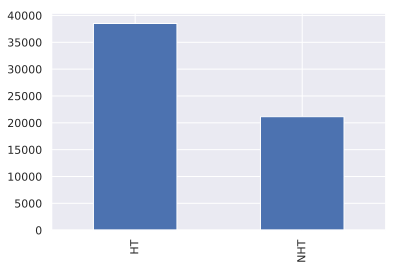

In [11]:
df['labels'].value_counts().plot.bar()

### 2a)- Encoding target feature

In [0]:

df['labels'] = df.labels.map({'NHT':'0', 'HT':'1'})

In [13]:
df.head()

,labels,visitor_recognition_type,country_by_ip_address,region_by_ip_address
0,0,ANONYMOUS,US,CA
1,0,ANONYMOUS,US,CA
2,1,ANONYMOUS,IT,LI
3,0,ANONYMOUS,US,CA
4,0,ANONYMOUS,US,CA


### 2b)-Encoding all categorical features


In [0]:
df_dummy=pd.get_dummies(data=df[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']], drop_first=True, dummy_na=True)

In [15]:
df_dummy.shape

(59638, 296)

**Split into target and input data i.e X and y**

In [0]:
X = pd.get_dummies(data=df[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']], drop_first=True,dummy_na=True)
y = df.labels

In [17]:
print(y.shape)
print(X.shape)

(59638,)
(59638, 296)


### Train and Test split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(47710, 296)
(11928, 296)
(47710,)
(11928,)


# 3)-ML Models

In [0]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("DT",DecisionTreeClassifier()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVM",SVC()))

In [21]:
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
for i in range(len(names)):
    print(names[i],results[i].mean())

LR 0.9801509117585411
NB 0.973841961852861
KNN 0.975372039404737
DT 0.980528191154894
RF 0.9804443512890378
SVM 0.9777614755816391


Random Forest performs best on training data with 98.08 accuracy.

**How about test data?**

In [22]:
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model,X_test,y_test, cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
for i in range(len(names)):
    print(names[i],results[i].mean())

LR 0.9800474805492894
NB 0.9708254105323562
KNN 0.9797960136590964
DT 0.9808857738373172
RF 0.9807180589231367
SVM 0.9699032246268782


[Text(0, 0, 'LR'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'DT'),
 Text(0, 0, 'RF'),
 Text(0, 0, 'SVM')]

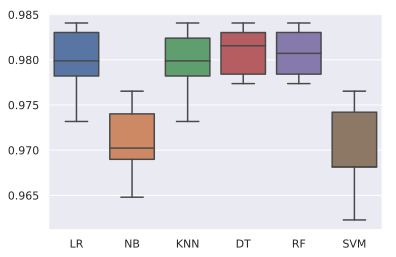

In [23]:
ax = sns.boxplot(data=results)
figsize=(16, 7)
ax.set_xticklabels(names)

# 4)- applying neural network

In [28]:
#create model, add dense layers one by one specifying activation function
model = Sequential()
model.add(Dense(15, input_dim=X_train.shape[1], activation='relu')) # input layer requires input_dim param
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid')) # sigmoid instead of relu for final probability between 0 and 1





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
# compile the model, adam gradient descent (optimized)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                4455      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 4,712
Trainable params: 4,712
Non-trainable params: 0
_________________________________________________________________


In [31]:
# call the function to fit to the data (training the network)
history=model.fit(X_train, y_train, epochs = 15, batch_size=20, validation_data=(X_test, y_test))

Train on 47710 samples, validate on 11928 samples
Epoch 1/15
47710/47710 [==============================] - 15s 313us/step - loss: 0.1213 - acc: 0.9613 - val_loss: 0.0678 - val_acc: 0.9800
Epoch 2/15
47710/47710 [==============================] - 14s 297us/step - loss: 0.0785 - acc: 0.9783 - val_loss: 0.0677 - val_acc: 0.9802
Epoch 3/15
47710/47710 [==============================] - 14s 292us/step - loss: 0.0758 - acc: 0.9791 - val_loss: 0.0683 - val_acc: 0.9799
Epoch 4/15
47710/47710 [==============================] - 14s 293us/step - loss: 0.0748 - acc: 0.9798 - val_loss: 0.0682 - val_acc: 0.9802
Epoch 5/15
47710/47710 [==============================] - 14s 292us/step - loss: 0.0743 - acc: 0.9795 - val_loss: 0.0681 - val_acc: 0.9799
Epoch 6/15
47710/47710 [==============================] - 14s 291us/step - loss: 0.0736 - acc: 0.9794 - val_loss: 0.0686 - val_acc: 0.9802
Epoch 7/15
47710/47710 [==============================] - 14s 292us/step - loss: 0.0733 - acc: 0.9794 - val_loss: 0.

In [0]:
y_pred_keras = model.predict(X_test)

In [33]:
y_pred_keras[:5]

array([[1.        ],
       [1.        ],
       [0.03697488],
       [0.03697488],
       [0.03697488]], dtype=float32)

In [0]:
#convert in crisp class
yhat_class_keras = model.predict_classes(X_test, verbose=0)

In [35]:
yhat_class_keras[:5]

array([[1],
       [1],
       [0],
       [0],
       [0]], dtype=int32)

In [36]:
y_test[:5]

53442    1
54717    1
31933    0
49496    0
789      0
Name: labels, dtype: object

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

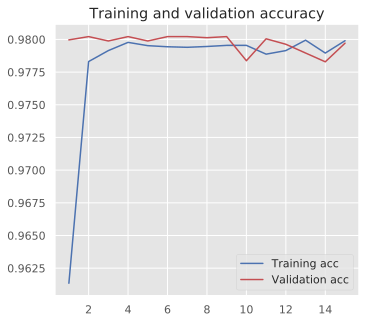

In [41]:
plot_history(history)

# 5)- Model Tunning

Adding more estimators, and playing with parameters..........I came up with better accuracy

In [42]:
rf = RandomForestClassifier(n_estimators=10,criterion='entropy', random_state=0)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
pred_rf[:5]

array(['1', '1', '0', '0', '0'], dtype=object)

In [44]:
print(accuracy_score(y_test, pred_rf))

0.9801307847082495


In [0]:
feature_of_importance=pd.Series(rf.feature_importances_, index=df_dummy.columns)

**Top 10 most important features**

In [74]:
feature_of_importance.head(10)

country_by_ip_address_AL    2.817918e-07
country_by_ip_address_AM    7.987340e-08
country_by_ip_address_AR    0.000000e+00
country_by_ip_address_AT    4.914803e-05
country_by_ip_address_AU    5.306866e-06
country_by_ip_address_BD    3.024489e-05
country_by_ip_address_BE    3.903870e-02
country_by_ip_address_BG    1.001324e-05
country_by_ip_address_BO    8.634576e-08
country_by_ip_address_BR    3.897996e-05
dtype: float64

**Top 10 least important features**

In [75]:
feature_of_importance.tail(10)

region_by_ip_address_WNA               6.109628e-08
region_by_ip_address_WP                0.000000e+00
region_by_ip_address_ZE                7.856781e-06
region_by_ip_address_ZG                0.000000e+00
region_by_ip_address_ZH                5.755266e-03
region_by_ip_address_ZP                1.368103e-05
region_by_ip_address_nan               0.000000e+00
visitor_recognition_type_LOGGEDIN      1.327704e-02
visitor_recognition_type_RECOGNIZED    2.400408e-02
visitor_recognition_type_nan           0.000000e+00
dtype: float64

### confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. Key matrix elements are:

- true positives (TP): These are cases in which we predicted yes (bot traffic), and actually they do have bot traffic i.e non-human.
- true negatives (TN): We predicted non-bot search traffic,actually they were.
- false positives (FP): We predicted bot traffic, but actually they were human generated traffic. (Also known as a "Type I error.")
- false negatives (FN): We predicted human traffic i.e non-bot, but they actually were bots. (Also known as a "Type II error.")

In [0]:
import itertools
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
cm = confusion_matrix(y_test, pred_rf)
cm

array([[4208,   31],
       [ 206, 7483]])

In [0]:
#save confusion matrix and slice into four piece
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

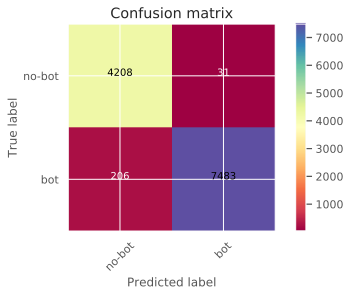

In [49]:
# False=0; True=1 ====> no-bot=0, bot=1
plot_confusion_matrix(cm, classes=['no-bot', 'bot'])

### Classification Report

In [50]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4239
           1       1.00      0.97      0.98      7689

    accuracy                           0.98     11928
   macro avg       0.97      0.98      0.98     11928
weighted avg       0.98      0.98      0.98     11928



# 6)-Matrics evaluation

### a)-Classification Accuracy
Overall, how often is the classifier correct?

In [52]:
print(accuracy_score(y_test, pred_rf))

0.9801307847082495


In [53]:
print((TP + TN) / float(TP + TN + FP + FN))

0.9801307847082495


So our model has made an improvement as of null accuracy was 67%. We got a good result of 93%

### b)-Classification Error
Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate

In [54]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, pred_rf))

0.0198692152917505
0.019869215291750453


### c)-Other matrices
- Sensitivity
- Specificity
- False Positive Rate
- Precision

### Sensitivity
When the actual value is positive, how often is the prediction correct?

How "sensitive" is the classifier to detecting positive instances? Also known as "True Positive Rate" or "Recall"

In [0]:
from sklearn.metrics import precision_score, recall_score, make_scorer
recall_scorer = make_scorer(recall_score, pos_label='bot')

In [56]:
#print(recall_score(y_test, pred_rf))
print(TP / float(TP + FN))

0.9732084796462479


### Specificity
When the actual value is negative, how often is the prediction correct?

How "specific" (or "selective") is the classifier in predicting positive instances?

In [57]:
# No sklearn formula

print(TN / float(TN + FP))

0.992686954470394


### False Positive Rate
When the actual value is negative, how often is the prediction incorrect?

In [58]:
print(FP / float(TN + FP))

0.007313045529606039


### Precision
When a positive value is predicted, how often is the prediction correct?

How "precise" is the classifier when predicting positive instances?

In [59]:
print(TP / float(TP + FP))
#print(metrics.precision_score(y_test, pred_rf))

0.9958743678466861


# 7)-Adjusting the classification threshold

In [60]:
# print the first 10 predicted responses
rf.predict(X_test)[0:10]

array(['1', '1', '0', '0', '0', '1', '0', '1', '0', '1'], dtype=object)

In [61]:
pred_rf[:10]

array(['1', '1', '0', '0', '0', '1', '0', '1', '0', '1'], dtype=object)

**predict_proba**

In [62]:
# print the first 10 predicted probabilities of class membership
rf.predict_proba(X_test)[0:10, :]

array([[0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.66917038e-01, 3.30829617e-02],
       [9.66917038e-01, 3.30829617e-02],
       [9.66917038e-01, 3.30829617e-02],
       [0.00000000e+00, 1.00000000e+00],
       [9.66917038e-01, 3.30829617e-02],
       [1.80069620e-04, 9.99819930e-01],
       [9.66917038e-01, 3.30829617e-02],
       [0.00000000e+00, 1.00000000e+00]])

In [63]:
# print the first 10 predicted probabilities for class 1 i.e bot
rf.predict_proba(X_test)[0:10, 1]

array([1.        , 1.        , 0.03308296, 0.03308296, 0.03308296,
       1.        , 0.03308296, 0.99981993, 0.03308296, 1.        ])

In [64]:
pred_prob_cl_one = rf.predict_proba(X_test)[:, 1]
print(pred_prob_cl_one[:5])

[1.         1.         0.03308296 0.03308296 0.03308296]


Text(0, 0.5, 'Frequency')

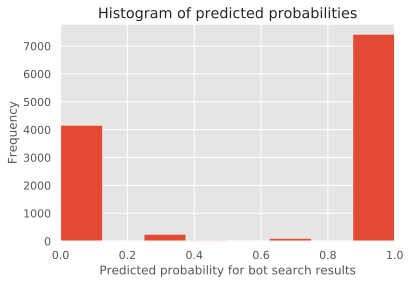

In [65]:
# histogram of predicted probabilities for bot traffic
plt.hist(pred_prob_cl_one, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for bot search results')
plt.ylabel('Frequency')

### Threshold value changing
For predicting bot search pattern in order to improve the Specificity of the classifier.

False positive (bot traffic are predicted as bot traffic incorrectly) matters more to us as we want to have imporoved stats for bot traffic. On other hand, False negative(human traffic are predicted incorrectly as bot traffic) is of less concern.

We need a classifer that is more specific for bot traffic and less sensitive towards human generated traffic.

In [0]:
from sklearn.preprocessing import binarize
y_pred_class_spec = binarize([pred_prob_cl_one], 0.9)[0]

In [0]:
y_pred_class_spec[0:10]

In [0]:
# check original confusion matrix
print(metrics.confusion_matrix(y_test, pred_rf))

In [0]:
# new confusion matrix (threshold of 0.9)
print(metrics.confusion_matrix(y_test, y_pred_class_spec))

In [0]:
# check value of  new specificity
print(TN / float(TN + FP))

In [0]:
# sensitivity new one
print(recall_score(y_test, y_pred_class_spec))

In [0]:
# Precison new
print(metrics.precision_score(y_test, y_pred_class_spec))

### ROC Curve

In [0]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob_cl_one)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for bot traffic')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for your particular context

You can't actually see the thresholds used to generate the curve on the ROC curve itself

In [0]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [0]:
evaluate_threshold(0.5)

In [0]:
evaluate_threshold(0.9)

In [0]:
print(classification_report(y_test, y_pred_class_spec))

### AUC
AUC is the percentage of the ROC plot that is underneath the curve:

In [0]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, pred_prob_cl_one))

In [0]:
from sklearn.metrics import auc
auc(fpr, tpr)

- AUC is useful as a single number summary of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation.
- Greater value close to 1 is better. If lower value i.e 0.5 then it is random guessing. In our case, it is good value

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve
prec, rec, thres = precision_recall_curve(y_test, pred_prob_cl_one)

def _plot_prec_rec_curve(prec, rec, thres):
    plot_pr = plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()
    #return plot_pr(it creates duplicate graph)

_plot_prec_rec_curve(prec, rec, thres)